# Datamigos - The Iron Curtain Dirty Movie Secret

During the Cold War, both the Western and Eastern blocs relied on soft power to spread ideological messages and influence global opinion, with cinema emerging as a key medium for this influence. We are interested in the way cinema served as a subtle but potent tool for political messaging during this period.

In this notebook, we will build a dataset suitable for exploring this subject and we will examine this problematic from three perspectives:
1. How international power dynamics and influence are reflected in film production.
2. How the themes and narratives of films were crafted to convey and promote specific ideologies.
3. How film characters were used, either as tools to manipulate populations or as mirrors of society.

**Table of content:**

- [Dataset and Cleaning](#Dataset-and-Cleaning)
- [Data Enhancement with GPT-4o mini and cleaning](#data-enhancement-with-gpt-4o-mini-and-cleaning)
- [A first glance at the data](#a-first-glance-at-the-data)
- [The reflection of internationnal dynamics and influences in film production](#the-reflection-of-internationnal-dynamics-and-influences-in-film-production)
- [Thematic and narrative strategies in movies to promote ideologies]()
- [What about movies characters?]()
- [Conclusion]() 

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import pyLDAvis
import pickle

from src.dataset_creation.cmu_merging_cleaning import *
from src.dataset_creation.datasets_merging import *
from src.dataset_creation.gpt_4o_data_enhancement import *
from src.dataset_creation.merged_dataset_preprocessing import *

from src.utils.constants import *
from src.utils.helpers import *

from src.analysis.intro import *
from ipyleaflet import Map, TileLayer, GeoJSON, Popup, WidgetControl
from ipywidgets import HTML

from src.analysis.intro import *
from src.analysis.country_side_map import *
from src.utils.collab_viz_helpers import *
from src.analysis.collab_viz import *
from src.analysis.languages_viz import *
from src.analysis.themes_genres.genre_theme_analysis import *
from src.utils.plots_template import *
from src.analysis.themes.topic_detection import *

warnings.filterwarnings('ignore')

## Dataset Merging and Cleaning

The first step was to build a suitable dataset for our project. It's important to note that the CMU Movie Summary Corpus was quite "America-centric," which was a bit problematic for our study. To address this, we extended it with the IMDB Non-Commercial Dataset and TMDb to achieve a more balanced representation, with more movies coming from other countries like the Soviet Union. Here is a brief description of the Datasets:

- [CMU Movie Summary Corpus](https://www.cs.cmu.edu/~ark/personas/):
    - **Movies Dataset** (`movie.metadata.tsv`) Includes comprehensive information about movies. It features data such as Wikipedia and Freebase IDs, movie names, release dates, box office revenues, runtimes, languages, countries, and genres.
    - **Plot Summaries Dataset** (`plot_summaries.text`): Offers a concise summary of movie plots, linked to movies through Wikipedia movie IDs.

- [The Movies Dataset (TMDb)](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset) contains metadata for 45,000 films listed in the Full MovieLens Dataset, all of which were released on or before July 2017. We will use this dataset, specifically the movies_metadata.csv file, primarily to enrich the movie.metadata.tsv of the CMU movie dataset. Additionally, this dataset includes plot keywords (in the keywords.csv file), which will be helpful for analyzing movie plots.

- [IMDB Non-Commercial Dataset](https://developer.imdb.com/non-commercial-datasets/) is a giant database containing over 50 Million movies from different regions, which allows us to complement our initial dataset specifically with movies created in the Soviet Union during the cold war. The CMU Movie Summaries data being largely focused on the United States.

In [2]:
# Load, merge and do some cleaning with our three datasets
merged_dataset = create_merged_dataset()

## Data Enhancement with GPT-4o mini and cleaning

We used the GPT-4o mini model to generate 6 new columns for our dataset. The columns are:
- `cold_war_side` - What side of the cold war the country belongs to if any
- `character_western_bloc_representation` - How the character representing the western block is portrayed 
- `character_eastern_bloc_representation` - How the character representing the eastern block is portrayed
- `eastern_bloc_values` - The values represented by the eastern block
- `western_bloc_values` - The values represented by the western block
- `theme` - The theme and keywords of the movie

This will be very useful later on to grasp the context of the movies and to understand the values and themes they represent.  

this is the prompt we used to generate the new columns:

> You are an expert in movie history and Cold War. You will be given the name of the film, the year and the plot of the movie. You first need to analyse if the movie can be identified to the Eastern or Western bloc during the Cold War. If yes come up with the character or group of character impersonating the Western and Eastern bloc and their values as well as their main archetye.
> Your output needs to be parsable comma separated without context (the output needs to start directly), use only keyword and very important use new line character after each of the following:
> - Cold War side belonging either Easter, Western or None.
> - The character or group of character representing Western bloc with their values and archetype comma separated or None.
> - The character or group of character representing Eastern bloc with their values and archetype comma separated or None.
> - The Western bloc representation main values and characteristics comma separated or None.
> - The Eatern bloc representation main values and characteristics comma separated or None.
> - The theme of the movies and keywords.
> If and only if the movie does not belong to any of the blocs, put `None` in the respective fields.



We need to parse all the output of GPT and clean it to be able to use it in our dataset.

In [3]:
merged_dataset_enhanced = create_enhanced_dataset()

We now do a final cleaning, processing and drop useless columns of the dataset to prepare it for analysis.

In [4]:
preprocess_movies = create_preprocessed_movies()

After data augmentation and pre-processing, we ended up with a dataset containing 25621 films released between 1945 and 1995, of which 2919 are classified as Eastern side and 3142 as Western side. In total, we identified 6,061 movies that could be associated with one of the blocs. They represent around 25% of our dataset with a good balance between the Western and Eastern blocs, which is a non-negligible proportion of our dataset.

In [5]:
plot_movies_distrib(preprocess_movies)

## A first glance at the data

We are now armed to start our analysis. We start by looking a little bit more in details at the number of movies produced by each country and their ideology.

In [6]:
country_counts_df = compute_side_movie_count_per_country(preprocess_movies)

# Display result
print(country_counts_df.head())

                    Country  Occurrences  Western  Eastern  None
0                    Russia        10853      720     2324  7809
1                     Italy         1374      139       71  1164
2                   Germany          645       68       42   535
3  United States of America         8239     1819      140  6280
4                   Estonia           72        7       13    52


We choose to use a heatmap in order to clearly put in evidence the countries that have produce the more films.

In [7]:
display_map_film_nb(country_counts_df)

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

The United States and Russia stand out as the main film producers during this period, with 8239 and 10853 films respectively. This clearly illustrates their global dominance and Soft Power. There are also a large number of films from European countries such as France, United Kingdom, Italy and Germany. These countries play a relevant role in our study and could prove essential in the analysis of international collaboration in the film industry.

We also examined the distribution of films over years throughout the Cold War to identify trends that could provide insights for our analysis.

In [8]:
plot_movies_distrib_by_year(preprocess_movies)

The number of films produced rose steadily. This suggests that cinema played an increasingly important role in the ideological conflict.

These were the results for all the films in our dataset. If we focusing exclusively on the films with a clear alignment toward one of the Cold War blocs, we observe the following distribution:

In [9]:
plot_evol_nb_movies(preprocess_movies)

c:\Users\chbou\anaconda3\Lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




From the beginning of the Cold War, the Western Bloc quickly seemed to take the lead in film production, or at least, the number of films classified as Western dominated. This was likely aimed at asserting its cultural and ideological power in response to rising tensions. The production of western oriented films can be seen as a strategy to promote capitalist and democratic ideals, not only to its own audience but also to influence allies – ensuring they did not switch sides – and neutral countries.

Between 1952 and 1959, the number of films representing Eastern values increased significantly, even surpassing those representing the West. This sudden rise seems to be a reaction from the USSR and its partisans, seeking to promote their communist ideals and counter the Western cultural influence. The number of Eastern-oriented films surpassed that of Western-oriented films until 1984. Subsequently, fluctuations were observed, followed by a sharp decline in 1989. This decline also affected Western films and coincided with the fall of the Berlin Wall. As tensions eased, films no longer needed to embody bloc-specific values as much as they did during the conflit.

## The reflection of internationnal dynamics and influences in film production

Clearly, the USA and the USSR are superpowers, demonstrating their superiority on all levels, including film production, as we've just seen. Yet beyond their status, these two nations seek to “dominate” the world and rally as many countries as possible to their ideology. To achieve this goal, they cannot act alone. They must form alliances to contain the expansion of their adversaries and warn off potential aggression.

Do these alliances manifest themselves in film production? To find out, we've examined the films produced by each country and classified them according to the number of East- or West-oriented films.

In [10]:
display_country_side_map(country_counts_df)

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

The choice of a heatmap allow us to clearly see the alliances formed during the Cold War, as we can mainly identify member countries of NATO and The Warsaw Pact.

If you take a closer look at European production, you can see the line of the Iron Wall. To the east of Germany, there is clearly a greater proportion of East-sided films. As the number of sided films per country is not necessarily huge, small differences between the number of west and east-sided films can quickly sway a country. Nevertheless, the result seems consistent with historical reality.

As mentioned above, the map once again shows the superiority of American and Russian productions in terms of numbers. As our dataset does not have much information for African and South American countries, we clearly see a lack of analysis possibilities in these regions on the map.

We do, however, have one clear initial result: film production was an important geopolitical propaganda tool during the Cold War. De facto, war imagery is a powerful tool for influencing the masses.

Another intriguing aspect of our dataset is the representation of countries involved in producing the movies, captured in the `countries` column. Analyzing this feature can provide valuable insights into the various strategies employed to promote the ideologies at play during this period.

A network is an effective way to visualize collaborations between countries. In this graph representation, each country is assigned to a node, with the size of the nodes proportional to the number of films the country has produced. Each node is also categorized based on the Cold War side, 'Western,' 'Eastern,' 'None,' or 'Lack of data', depending on the proportion of politically engaged movies the country has produced. Additionally, the edges between nodes represent collaborations between countries, with their thickness and transparency increasing as the number of collaborations grows.

In [11]:
graph = StaticGraph(preprocess_movies)
graph.create_figure()
graph.plot()

While the graph representation provides a wealth of interesting insights, visualizing it on a map could highlight additional compelling aspects of the network, such as geographical patterns or regional dynamics in collaborations.

In [12]:
map = StaticMap(preprocess_movies)
map.create_figure()
map.plot()

**Observations:**

Both visualizations of movies co-productions during the Cold War offers an insight into the political dynamics of the time. We have to keep in mind that, in this representation, the former countries of the USSR are considered individually, allowing for a nuanced understanding of their international relations.

A key observation is the tendency to form numerous co-productions between the United States and the Western European countries. This surge in collaborations could be seen as a strategic effort from the US to strengthen political and cultural ties with allies, using film as a tool for soft power during the Cold War.

In stark contrast, the USSR appears to have limited co-production in the film industry. This lack of collaboration may be attributed to the desire of Soviet authorities to retain full control over the narratives, allowing them to use cinema as a vehicle for their propaganda. This theory is further supported by the highly centralized nature of the Soviet film industry, where the government tightly regulated production, unlike in the more decentralized Western bloc. Additionally, it is worth considering the cultural context. [The theatre attendance in the USSR during this period was significantly higher than in the US](https://www.statista.com/statistics/1249401/movie-theater-attendance-us-ussr-cold-war/), suggesting that the domestic market was flourishing enough to reduce the urgency for international collaborations.

Interestingly, despite occasional connections with Western nations, the countries situated in the center and north of Europe preserved their neutral positioning, navigating the global tension with cautious diplomacy. Switzerland, for instance, got some ties with the Western bloc in film productions and yet remained largely neutral in its political engagement.

Japan and Hong Kong present unique cases in the graph. Japan, while often neutral in its Cold War alignment, shows a notable collaboration with the US, revealing an underlying rapprochement despite the country's apparent neutrality. On the other hand, Hong Kong, though geographically in communist China, remains neutral in the context of the Cold War. That’s because of the city’s historical ties to the UK, making it a unique strategic position at the crossroads of East and Western ideologies.

The previous graph representations included all countries and all connections between them. If you wish to go deeper into the exploration, we provide two interactive plots that allow you to adjust the minimum number of movies required for a country to be represented and the minimum number of co-productions needed for a connection to be displayed.

N.B: Only the first graph is plot here. The code line to display the other one is commented.

In [13]:
dynamic_graph = DynamicGraph(preprocess_movies)
dynamic_graph.plot()

#dynamic_map = DynamicMap(preprocess_movies)
#dynamic_map.plot()

Turning to the analysis of language distribution in films during the Cold War, we observe that English is by far the most commonly used language. This finding strongly reinforces our observations of the spread of US soft power, shaping global cultural trends and making English the dominant language in international cinema. This could be seen as part of a bigger geopolitical strategy, with American cultural influence reaching far beyond its borders. However, it is important to mitigate this observation, as the United Kingdom was for the most part English-speaking. Therefore, the prominence of English is also a reflection of its established role in global film production.

In [14]:
plot_top_languages(preprocess_movies, 25)

When we delve deeper into the language distribution for each bloc, the trend of English dominance remains consistent, even within films produced by Eastern bloc countries. This is a striking observation, as it highlights the reach of US cultural influence, which managed to penetrate even the closed-off environments of Eastern bloc cinema. The widespread use of English in the Eastern bloc suggests that the USA made important efforts to spread its cultural ideals, creating an undeniable link between language and political influence.

In [15]:
plot_top_lang_per_side(preprocess_movies, 20)


Interestingly, this phenomenon also hints at the reverse: Eastern bloc countries may have seen the benefit of using English to promote their ideas and narratives to Western audiences. In the context of the Cold War, where ideological battles were especially fought through cultural influence, the use of English in Eastern bloc films could be viewed as an attempt to make their voices heard within the global conversation.

## Thematic and narrative strategies in movies to promote ideologies

The genre of a movie is one of the first classifications that one can look at to understand the sort of movie one is about to watch. It is therefore interesting to look at how the distribution of genres differ across both sides, and how they evolved over time.

In [16]:
genres_df, common_genres = clean_genre_explode(preprocess_movies)

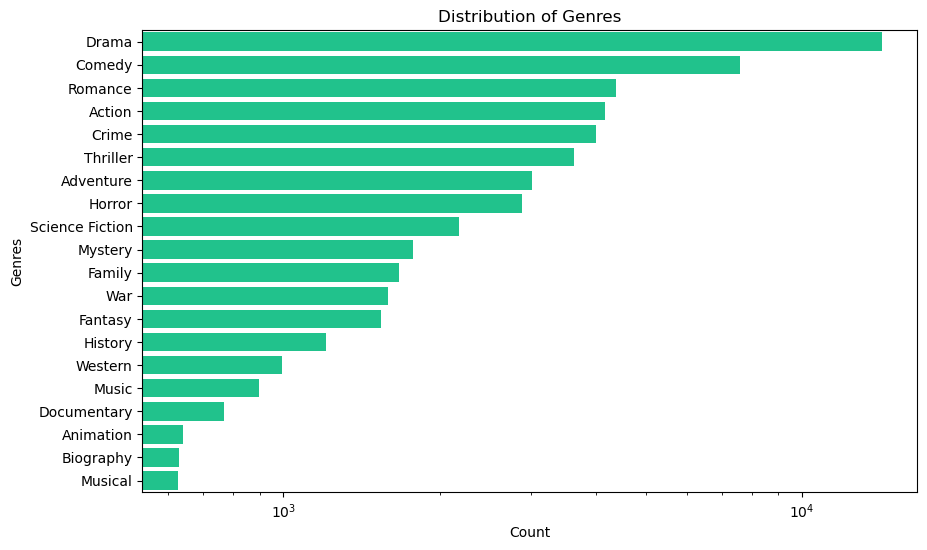

In [17]:
plot_distribution(genres_df, "genres", log_scale=True)

Then Plot the distribution of genres for the movies we are studying (those either in the "Eastern" cold_war_side or the "Western" cold_war_side)

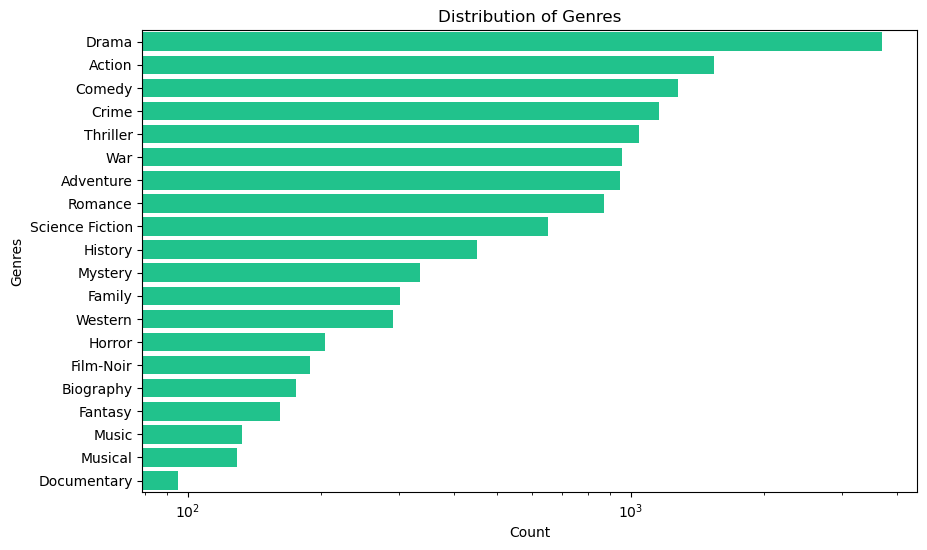

In [18]:
genres_df = genres_df[genres_df["cold_war_side"].isin(["Eastern", "Western"])]
plot_distribution(genres_df, "genres", log_scale=True)

Now plot the distribution of genres per side

In [19]:
western_genre_counts = genres_df[genres_df["cold_war_side"] == "Western"][
    "genres"
].value_counts()
eastern_genre_counts = genres_df[genres_df["cold_war_side"] == "Eastern"][
    "genres"
].value_counts()


fig = plot_side_by_side(
    western_genre_counts.reset_index(),
    eastern_genre_counts.reset_index(),
    x_column="genres",
    y_column="count",
    title="Top 20 Genres",
)

fig.write_html(
    WEB_EXPORT_FOLDER + "top_genres_per_side.html",
    full_html=True,
    include_plotlyjs="cdn",
    config={"responsive": True},
)

Most of the genres appear in the same frequency in both sides. We can instead look at the relative difference between genre count in the eastern side and the western side.

$\textit{relative\_difference} = \frac{\textit{Eastern\_count} - \textit{Western\_count}}{\textit{Eastern\_count} + \textit{Western\_count}}$

In [20]:
genre_comparison = create_comparison_df(western_genre_counts, eastern_genre_counts, 20)

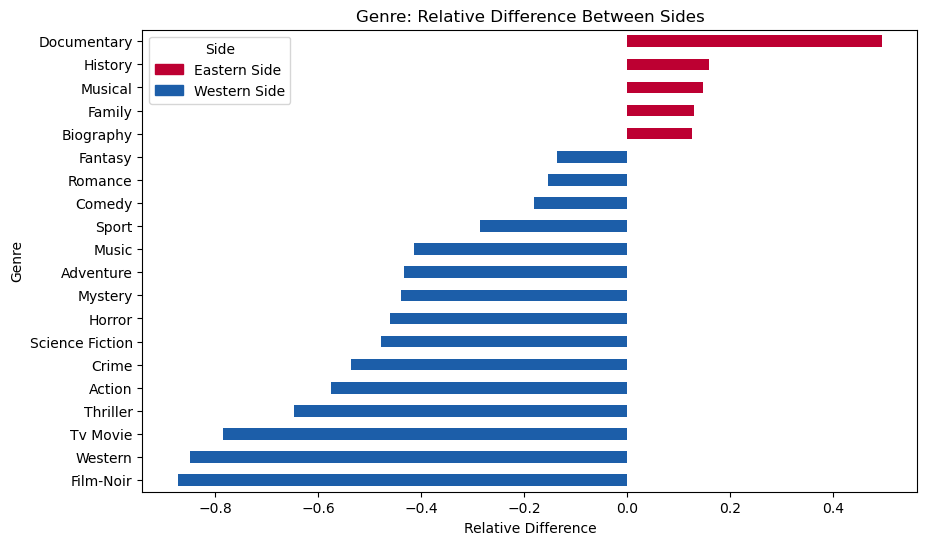

In [21]:
plot_relative_difference(genre_comparison, "Genre", abs=False, prop=False)

We can look at the relative difference in proportion instead

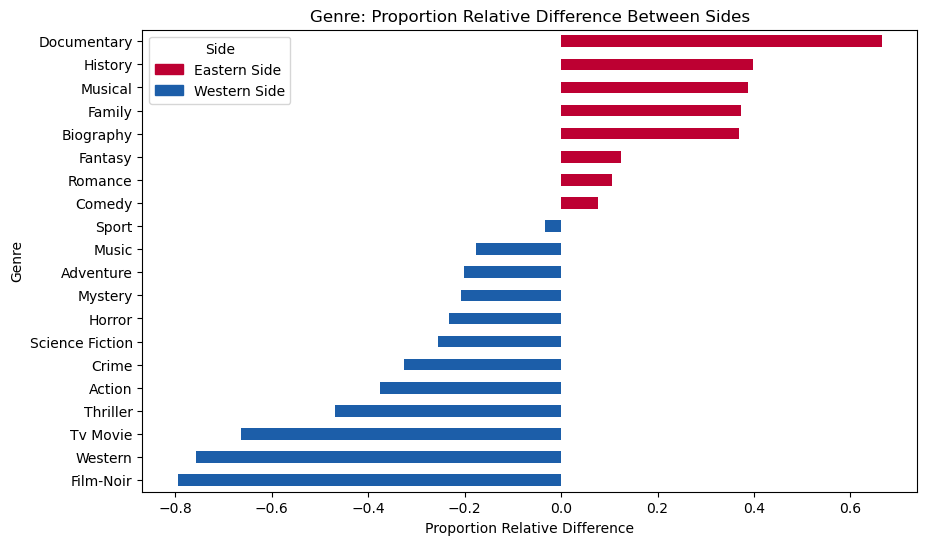

In [22]:
plot_relative_difference(genre_comparison, "Genre", abs=False, prop=True)

Documentaries and Historical movies appear far more in the eastern bloc, while Thrillers, Actions are more prevalent in the western bloc.
It is not surprising that westerns and film-noirs are a lot more common in the western side.

### Time Series

We can look now how the genre frequency changed over time.

First plot the count every year
Then plot the count each period (either every 5 years or through cold war periods)

In [23]:
western_genres_yearly_counts, eastern_genres_yearly_counts = get_genres_yearly_count(
    genres_df, common_genres
)

In [24]:
plot_interactive_genre_over_time(
    western_genres_yearly_counts, eastern_genres_yearly_counts, common_genres
)

interactive(children=(Dropdown(description='Region', options=('Western', 'Eastern'), value='Western'), Output(…

<function src.analysis.themes_genres.genre_theme_analysis.plot_interactive_genre_over_time.<locals>.interactive_plot(side_genres)>

Either change the Side by interaction.

In [25]:
plot_interactive_genre_over_period(genres_df, common_genres)

interactive(children=(Dropdown(description='Region', options=('Western', 'Eastern'), value='Western'), Output(…

<function src.analysis.themes_genres.genre_theme_analysis.plot_interactive_genre_over_period.<locals>.interactive_plot(side_genres)>

Or make Genres interactive.

In [26]:
plot_interactive_side_over_period(genres_df, common_genres)

interactive(children=(Dropdown(description='Genre', index=11, options=('Drama', 'Comedy', 'Romance', 'Action',…

We plot the average number of movies per year because the periods do not have the same duration, and thus any result we would get without averaging first would be misleading.

We see that war movies begin decreasing in frequency starting from the detente period.

### Theme Analysis

We do similar analysis for themes

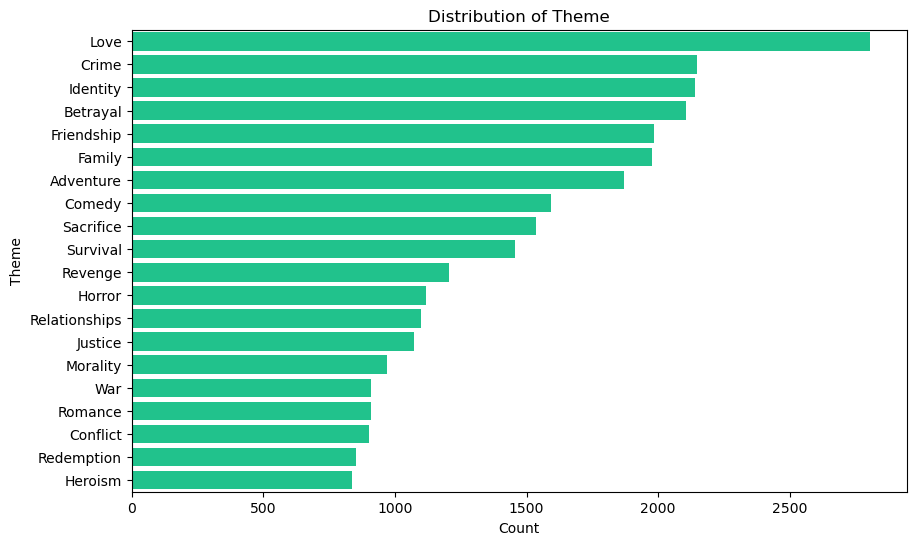

In [27]:
themes_df = (
    preprocess_movies[["genres", "cold_war_side", "theme", "release_date"]]
    .explode("theme")
    .reset_index()
)
themes_df["theme"] = (
    themes_df["theme"]
    .str.title()
    .str.strip()
    .replace({"Wwii": "World War II", "World War Ii": "World War II"})
)
themes_df = themes_df[themes_df["theme"] != "None"].dropna(subset=["theme", "genres"])

plot_distribution(themes_df, "theme")

In [28]:
western_theme_counts = (
    themes_df[themes_df["cold_war_side"] == "Western"]["theme"]
    .explode("theme")
    .value_counts()
)
eastern_theme_counts = (
    themes_df[themes_df["cold_war_side"] == "Eastern"]["theme"]
    .explode("theme")
    .value_counts()
)

fig = plot_side_by_side(
    western_theme_counts.reset_index(),
    eastern_theme_counts.reset_index(),
    x_column="theme",
    y_column="count",
    title="Top 20 Themes",
)

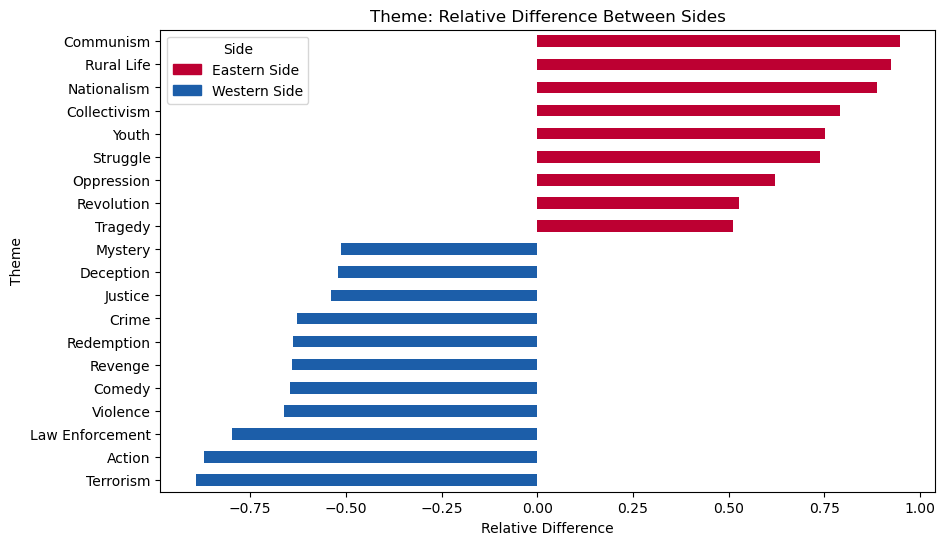

In [29]:
theme_comparison = create_comparison_df(western_theme_counts, eastern_theme_counts, 50)
plot_relative_difference(theme_comparison, "Theme")

Although this already showcases relevant differences, it might be more interesting to look at specific examples. (more in-depth theme analysis will come later).

We can look at themes present in War Movies Specifically.

In [30]:
western_war_themes_counts, eastern_war_themes_counts = get_side_war_theme_counts(
    themes_df
)

In [31]:
fig = plot_side_by_side(
    western_war_themes_counts.reset_index(),
    eastern_war_themes_counts.reset_index(),
    x_column="theme",
    y_column="count",
    title="Top 20 Themes for War Movies",
)
fig.write_html(
    WEB_EXPORT_FOLDER + "top_war_themes_per_side.html",
    full_html=True,
    include_plotlyjs="cdn",
    config={"responsive": True},
)

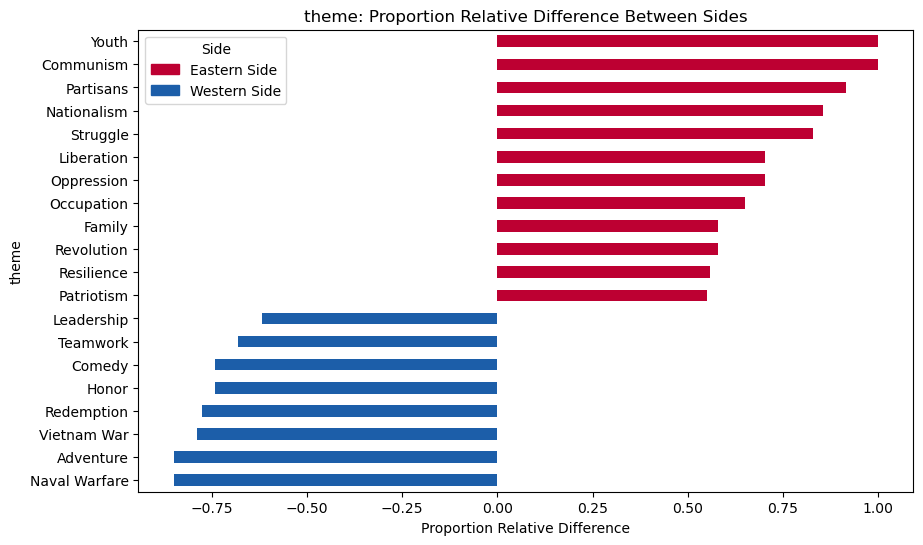

In [32]:
war_theme_comparison = create_comparison_df(
    western_war_themes_counts, eastern_war_themes_counts, 10
)

plot_relative_difference(war_theme_comparison, "theme", prop=True)

Comedy, Adventure more common in the west <br/>
Vietnam War also prevalent.

Struggle, Oppression, Resilience more common in the east.


Difference in representation of war movies reveals difference in ideology.

For more in-depth analysis of the themes present in the movies displayed in cinemas for western and eastern audiences, we will attempt to group into categories based on the overall tone and topic.

### Evolution of Film Themes Across Cold War

Our dataset includes many themes for each movies. A topic detection would allow us to better understand the evolution and influence of the different periods of the cold war to see both.
- the cultural differences between the Western and Estern bloc 
- the repercussion of political tensions on the film scene

In [ ]:
theme_df = create_theme(preprocess_movies)

As we have a dataset with une unlabeled data, we cannot perform document classification and must apply topic detection techniques to detect spectific character archetypes. 

So we model the problem as follow.

We considered each movies' themes as a single document. Hence our corpus is composed of all the movies' themes. The difference with a classic document is that we only have few words our groups of words instead of a lot of number of phrases. But as these techniques works for tweets which have a limited number of characters, this should not be really different from the data we have for our themes.

We chose to use Latent Dirichelet Allocation Model (LDA) for 2 reasons:
- The probabilistic nature of the model, which assumes that documents are mixtures of topics and that topics are mixtures of words. This probabilistic nature allows for a more nuanced understanding of the data compared to deterministic models; and that's exactly what we are looking at to study movies' themes. Indeed, each movies cover multiples themes and LDA's ability to model documents (in this case, movies' themes) as mixtures of topics allows for a more nuanced understanding of these themes and also a less biased clustering.
- The interpretability of the results by representing topics as distributions over words. Each topic is represented by a set of words with associated probabilities, making it easier to cluster themes in relevant groups.

Of course, we did not directly input our themes clusters representation to the model. We first have to preprosses the movies' themes. Even if they are already list of strings, we still need to preprocess them, removing the stopwords and the punctuation using an nlp. After few trials of LDA analysis, we also decided to removed some words that where so present in the corpus that they act as stopwords and influenced to much the topic detection.

Once the preprocessing was done, we "only" had to create a dictionary (mapping each unique word to a unique interger id) from our themes representation, create the bag of word for each themes representation (the corpus), and feeding the LDA model with the corpus, the dictionnary and the number of topics we wanted.

As the training takes a long time and is not deterministic, we load the results from a previous run. The commented code bellow can be used to train the model from scratch if needed.

In [ ]:
# theme_topic = create_theme_topics(theme_df)
theme_topic = pickle.load(open("src/analysis/themes/theme_topic.pkl", "rb"))

theme_df, eastern_theme, western_theme = get_eastern_western_theme_topics(theme_df, theme_topic)

In [ ]:
model = get_model(theme_topic)
pyLDAvis.display(model)

In [ ]:
print_topics(theme_topic)

Based on the words in each topic, we can infer the following movie themes:
- 1st cluster: **War & Spy Dramas**
- 2nd cluster: **Crime & Moral Thrillers**
- 3rd cluster: **Romance & Social Drama**
- 4th cluster: **Political Dramas**

Let's now dive deeper into the key differences between the Eastern and Western movies.

We separate the movies into 4 periods:
- (1947-1953): The end of WWII and the beginning of the Cold War
- (1954-1962): Cold War marked by great tensions and crises
- (1963-1974): The Déntente period with a relaxation of tensions
- (1975-1984): The Second Cold War with a new wave of tensions
- (1985-1994): The end of the Cold War

For each period and for each theme, we count the number of Eastern and Western movies.

In [ ]:
eastern_df, western_df = create_eastern_western_topics_periods(eastern_theme, western_theme)
eastern_df

,Romance & Social Dramas,War & Spy Dramas,Crime & Moral Thrillers,Political Dramas
Begin (47-53),46,25,99,32
Crisis (54-62),134,110,290,102
Detent (63-74),217,178,335,149
Second CW (75-84),130,139,301,95
End (85-91),53,93,155,68


In [ ]:
western_df

,Romance & Social Dramas,War & Spy Dramas,Crime & Moral Thrillers,Political Dramas
Begin (47-53),138,153,106,42
Crisis (54-62),199,205,160,57
Detent (63-74),255,197,112,81
Second CW (75-84),167,161,118,66
End (85-91),203,144,109,61


We plot the results in a bar plot to visualize the evolution of the themes in the Eastern and Western movies over time.

In [ ]:
fig = plot_distribution_topic_periods_side(eastern_df, western_df)

However, this representation does not allow us to see the full picture as the periods are unbalanced in term of the number of movies. A better representation would be to use the ratio of each theme for each periods to better understand the evolution of the film scene across the two blocs.

In [ ]:
fig = plot_normalised_distribution_topic_periods_side(eastern_df, western_df)

Main findings:
- The differences between Eastern and Western movies lie more in the overall themes than in the evolution of these themes over periods. This suggests that the differences between the two blocs are more related to a cultural divide.
- Estern movies are more focused on **Crime & Moral Thrillers** whereas Western movies themes are more balanced accross the four themes.
- The Détente period is marked by a decrease in **War & Spy Dramas** and an increase in **Romance & Social Drama** in both Eastern and Western movies.
- *War & Spy Dramas* are rising in the Eastern movies during the whole Cold War period. 